# Band Removal
This notebook looks for an analytic method that finds the random band across the 0.3s images and then removes it. The reason for this is that when the CNN tries to analyze the images, the band across the image forms an imperfection that the network has difficulty learning. For patches entirely within the band it isn't a problem, but for patches that cross the band the network cannot adequately deal with the split brightness in the different sectinons of the image. I tried to train the network using fake bands, but even still it couldn't handle it, and hence I developed a robust (~90% of the time) method for removing the band.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import signal
from scipy import ndimage
import os
import random

First I experimented using an edge finding convolution to see if we can find the band using edge detection. Unfortunately the edge is too dim to be found this way.

dtype('uint8')

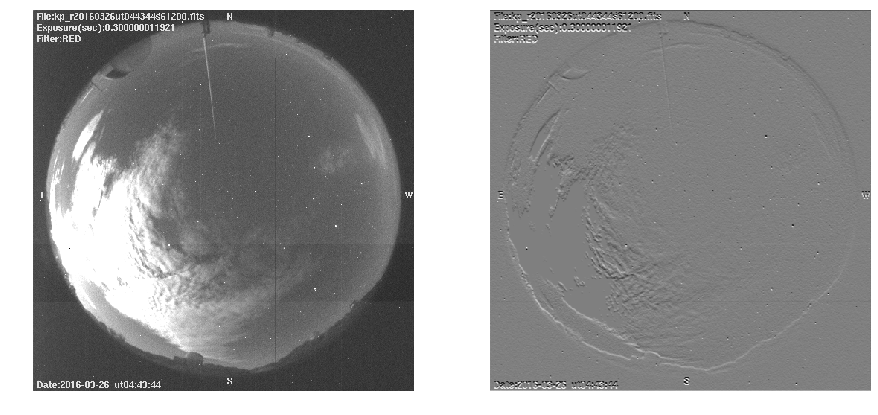

In [8]:
#%%time
#name = 'r_ut081523s74880.png'
name = 'r_ut044344s61200.png'
#name = 'r_ut074448s57900.png'
loc = os.path.join('../Images', *['data', 'train', '0.3', name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im)#.reshape((512, 512))

im2 = 255-im

filt = np.array([[-3, -10, -3],[1, 0, -1],[ 3, 10, 3]])

im3 = signal.convolve2d(im, filt, mode='same')
im3 = im3

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(im, cmap='gray')
x = [255,257]
ax[0].set_xticks(x)
ax[0].grid(True, color='c')
ax[1].imshow(im3, cmap='gray')

im.dtype

This plots two vertical and horizontal ines to demosntrate which verical column of pixels I'm using.

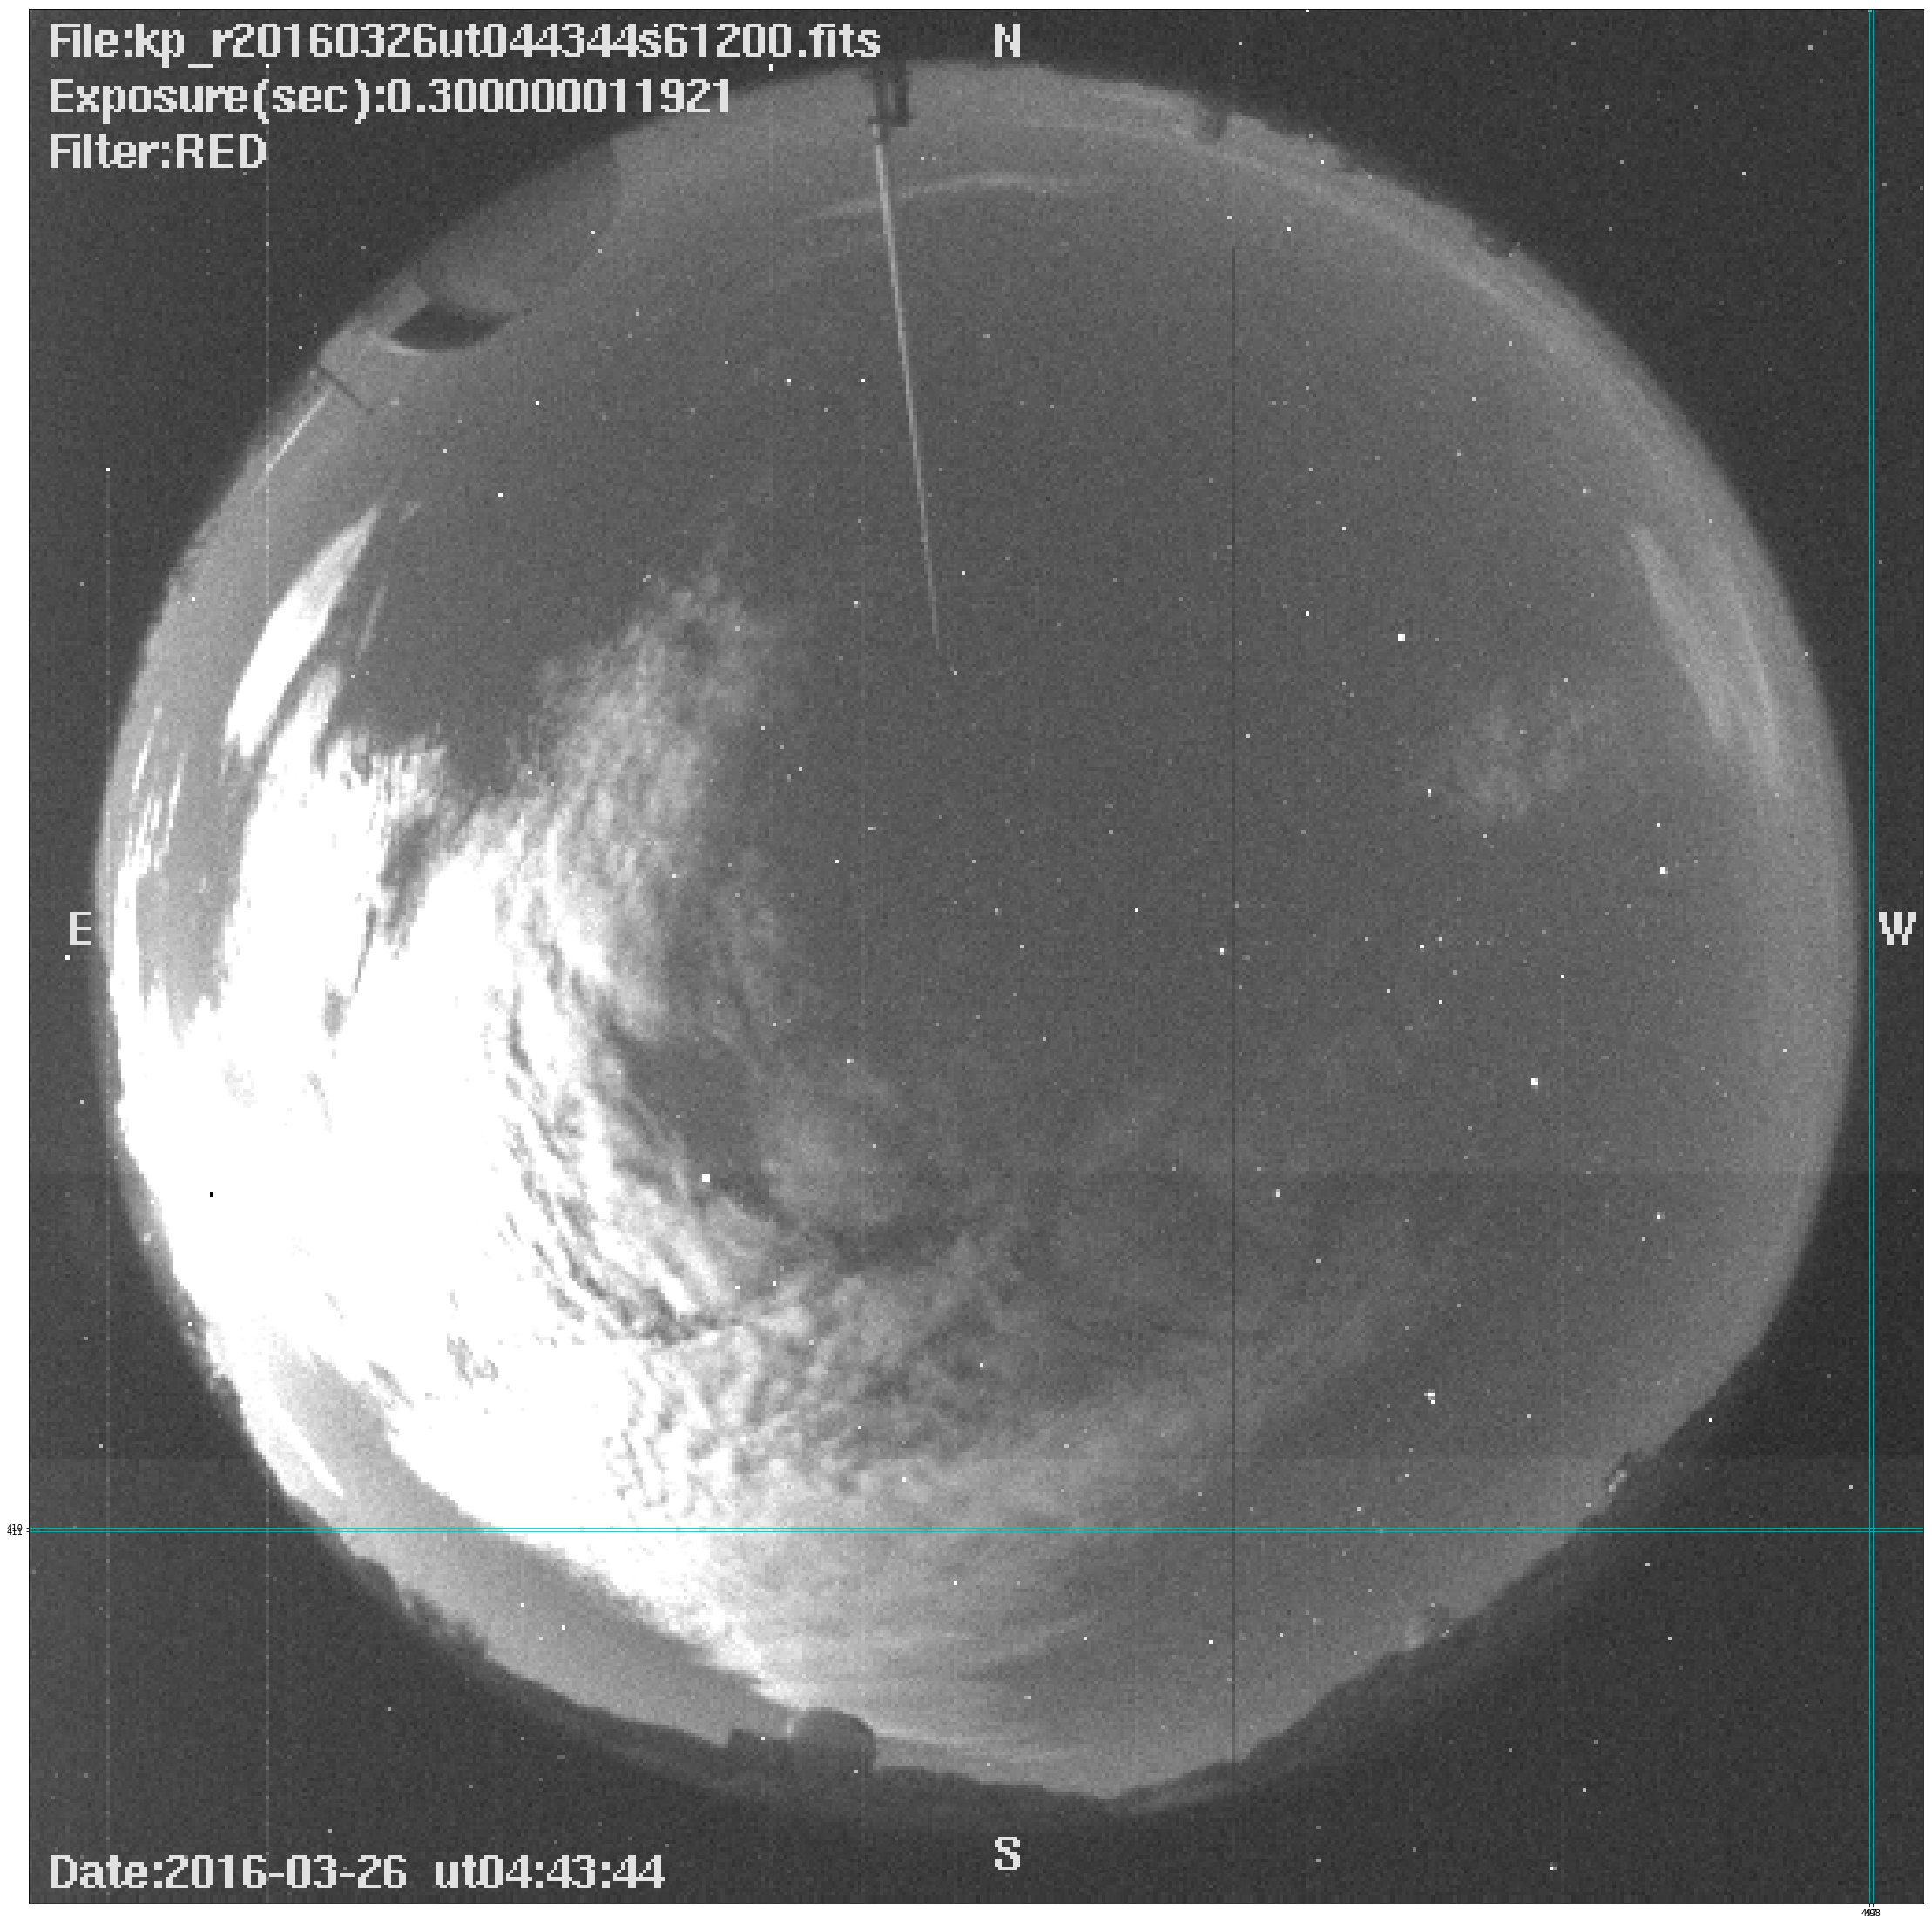

In [152]:
fig,ax = plt.subplots()
fig.set_size_inches(40,40)
plt.imshow(im, cmap='gray')
minus = 15
x = np.array([512-minus,512-minus+1])
plt.xticks(ticks=x)
y = np.array([256+154,256+155])
plt.yticks(ticks=y)
plt.grid(color='c')
plt.savefig('pixel.png', bbox_inches='tight')

We run some smoothing over the image to reduce fine-grain that appears in the image.

CPU times: user 50.7 ms, sys: 4.79 ms, total: 55.4 ms
Wall time: 60.1 ms


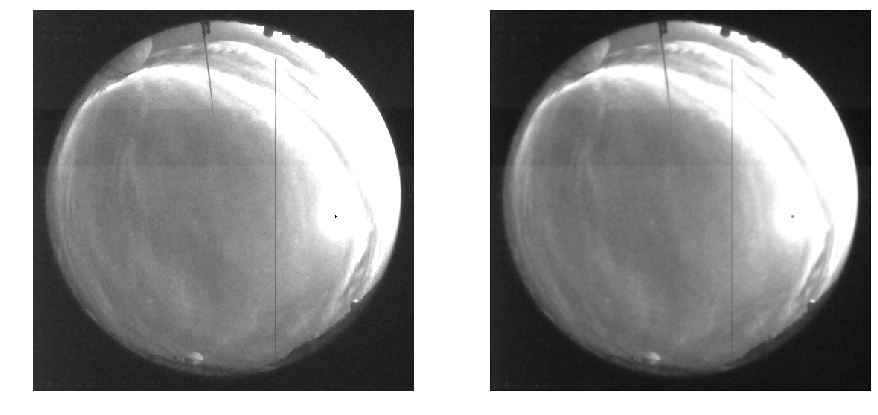

In [11]:
%%time
#name = 'r_ut081523s74880.png'
name = 'r_ut044344s61200.png'
#name = 'r_ut041252s80160.png'
name = 'r_ut033417s75000.png'
loc = os.path.join('../Images', *['fix1', name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im)#.reshape((512, 512))

im2 = ndimage.grey_opening(im, size=(3,3))

filt = (1/9) * np.ones((3,3))

im3 = signal.convolve2d(im2, filt, mode='same')
#im3 = im3

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(im2, cmap='gray')
ax[1].imshow(im3, cmap='gray')

In this cell we plot the pixel values of the single column we used. I plotted two vertical yellow lines where the band is determined to be using the aglorithm. The red lines are at the start of the band in an older image. The cyan line Is the average value of the pixel and the next 77 pixels down the column. 77 Pixels is the lenght of the band I determined from visual inspection. The horizontal red line is at the mean pixel value for the column and the horizontal green line is at the mean minus 1 standard deviation.

434
8
501
CPU times: user 29.3 ms, sys: 4.5 ms, total: 33.8 ms
Wall time: 33.1 ms


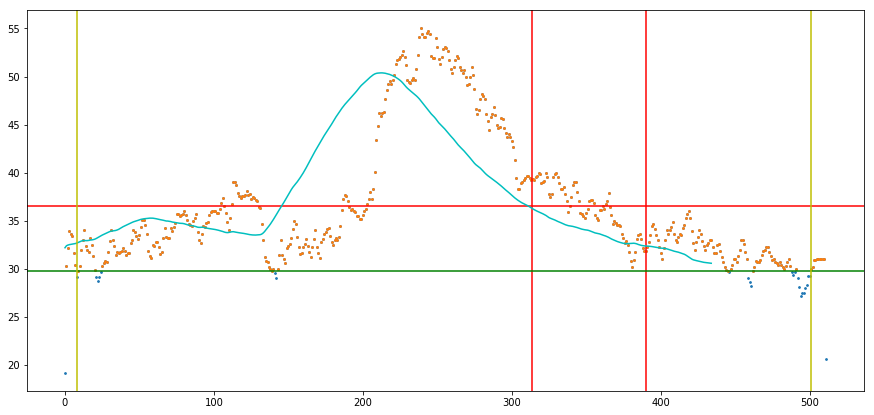

In [12]:
%%time
y = im[0:,-15]
x = np.arange(0, len(y))
y2 = np.copy(y)
#y2[314:390] = y2[314:390] * (1/0.9)

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
#ax[0].scatter(x, y, s=2)
#ax[0].scatter(x, y2, s=2, c='m')
#ax[0].axvline(x=313.5, c='r')
#ax[0].axvline(x=390.5, c='r')

y3 = np.copy(im3[0:,-14])
#y3[315:392] = y3[315:392]*(1/.93)
ax.scatter(x, y3, s=3)
ax.axvline(x=313.5, c='r')
ax.axvline(x=390.5, c='r')
ax.axhline(y=np.mean(y3), c='r')

y3_r = np.flip(np.asarray(y3))

y4 = []
y5 = []

length = 77

for i in range(0, 512-length):
    y4.append(np.mean(y3[i:i+length]))
    y5.append(np.mean(y3_r[i:i+length]))

x2 = np.arange(0, len(y4))
ax.plot(x2, np.asarray(y4), c='c')

#x3 = np.arange(0, len(y5)) + length
#ax[1].plot(x3, np.flip(np.asarray(y5)), c='m')

start = np.argmin(y4)
print(start)
#print(np.min(y4))
#print(np.mean(y3))

# The first index where the mean of that 77 length slice is larger than the mean of the entire column
#run = y5[start+5:start+80]
#ind = np.where(np.where(y4 > np.mean(y3))[0] > np.argmin(y4))[0][0]
#print(np.where(y4 > np.mean(y3))[0][ind])

#ind = np.argmax(run)
#print(512 - np.argmin(y5))

above = y3 > (np.mean(y3) - np.std(y3))
minimum = 30
testingarea = above[3:]
start = np.argmin(testingarea) + 3

print(start)

mask = np.ones(len(y3), dtype=bool)
mask[start:start+77] = False
ax.axhline(y=np.mean(y3) - np.std(y3), c='g')

ax.axvline(x=start, c='y')

above2 = y3_r > (np.mean(y3) - np.std(y3))
minimum = 30
testingarea = above2[3:]
end = 512 - np.argmin(testingarea) - 3

print(end)

abvs = y3[above]
x2 = np.arange(0, len(y3))
ax.scatter(x2[above], abvs, s=3)

ax.axvline(end, c='y')

Similarly to the above, yellow lines indicate where the band was found and cyan is the average of the pixel and the next 77 pixels.

492
569


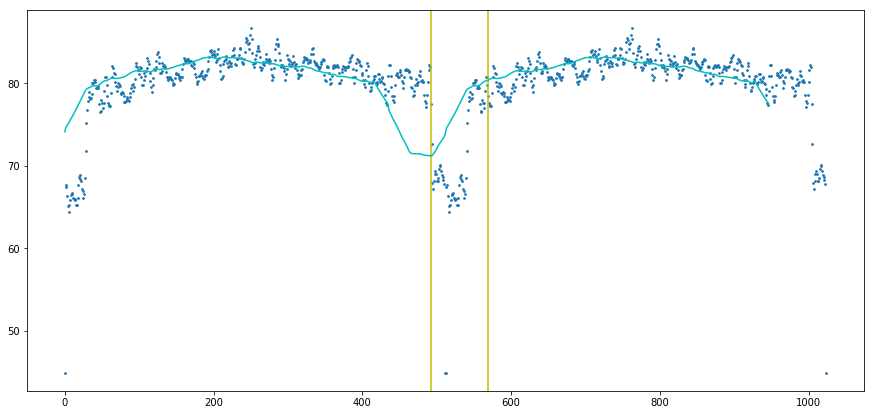

In [14]:
name = 'r_ut024049s56880.png'
name = 'r_ut044344s61200.png'
#name = 'r_ut041252s80160.png'
name = 'r_ut043049s81240.png'

loc = os.path.join('../Images', *['fix1', name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im)#.reshape((512, 512))

im2 = ndimage.grey_opening(im, size=(3,3))
#im2 = ndimage.grey_closing(im2, size=(3,3))
filt = (1/6) * np.array([[1,1,1],[1,1,1],[1,1,1]])

im3 = signal.convolve2d(im2, filt, mode='same')

y3 = np.copy(im3[0:,-10:])
y3 = np.mean(y3, axis=1)
y3 = np.concatenate([y3,y3])
#y3 = np.where(y3 < 20, 40, y3)
#m = np.mean(y3)
#y3 = 7*(y3-m) + m

length = 77
y4 = []
for i in range(0, len(y3)-length):
    y4.append(np.mean(y3[i:i+length]))
    
start = np.argmin(y4)
end = start + 77

x = np.arange(0, len(y3))
fig, ax = plt.subplots()
fig.set_size_inches(15,7)
ax.scatter(x, y3, s=3)
# 313-390 ish
ax.axvline(start, c='y')
ax.axvline(end, c='y')

x2 = np.arange(0, len(y4))
ax.plot(x2, np.asarray(y4), c='c')

print(start)
print(end)

And now we brighten the band that we found and demonstrate the method's validity! I experimentally determined that the band is ~90% of the brightness of the rest of the image. In order to undo this we multiply the band by 1/0.9. In this cell I manually input the band's location. I haven't joined the method with the brightness yet.

CPU times: user 59.4 ms, sys: 16.4 ms, total: 75.8 ms
Wall time: 78.2 ms


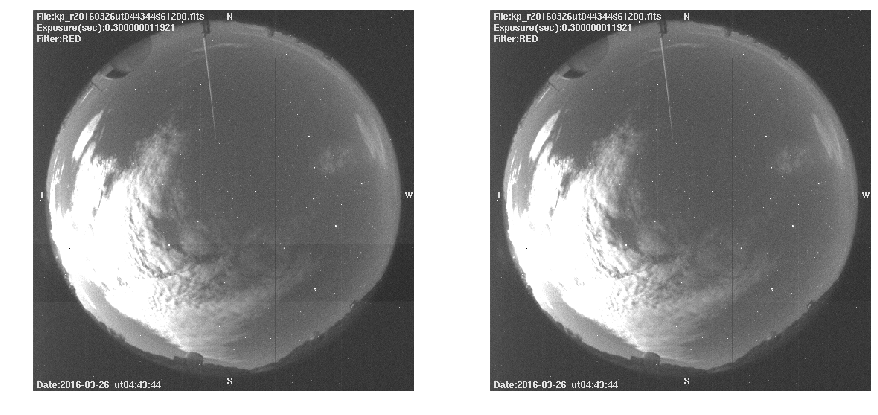

In [15]:
%%time
#name = 'r_ut081523s74880.png'
name = 'r_ut044344s61200.png'
#name = 'r_ut074448s57900.png'
loc = os.path.join('../Images', *['data', 'train', '0.3', name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im)#.reshape((512, 512))

im3 = np.copy(im)
im3 = im3.astype(np.uint16)
im3[314:392,...] = im3[314:392,...] * 1/0.90
im3 = np.where(im3 > 255, 255, im3).astype(np.uint8)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(im, cmap='gray')
ax[1].imshow(im3, cmap='gray')

The first fix method is the first fixing method I used. We run through every 77 length slice of the vertical column and looked for the 77 slice that had the lowest mean. There are some instances where this, unfortunately doesn't work, the largest one being if the  band is actually split in two, running across the top and bottom of the image. In this case I tried to account for it by looking for the end of the band. I did this by finding the first time above the starting value (found as noted) that the pixel value exceeds the mean minus one standard deviation.

In [16]:
def fix(im):
    filt = (1/9) * np.array([[1,1,1],[1,1,1],[1,1,1]])
    im2 = signal.convolve2d(im, filt, mode='same')
    
    y = im2[0:,-15]
    
    y4 = []
    y5 = []
    for i in range(0, 512-77):
        y4.append(np.mean(y[i:i+77]))
        y5.append(y[i+1] - y[i])
    
    start = np.argmin(y4)# - 1
    print(start)
    
    # Greater is all times the average of the 77 slice is larger than the mean of the entire column.
    #greater = np.where(y4 > np.mean(y))[0]
    
    # Then we find the first time where greater is true, that is above the starting index.
    #ind = np.where(greater > start)[0][0]
    #end = greater[ind]
    #y5 = np.asarray(y5)
    #run = y5[start+5:start+80]
    #ind = np.argmax(run)
    #end = ind + start + 7
    #print(end)
    
    above = y > (np.mean(y) - np.std(y))
    minimum = 29
    testingarea = above[start+minimum:]
    end = np.argmax(testingarea) + start + minimum

    print(end)

    im3 = np.copy(im)
    im3 = im3.astype(np.uint16)
    im3[start:end,...] = im3[start:end,...] * 1/0.93
    im3 = np.where(im3 > 255, 255, im3).astype(np.uint8)
    return im3

The second fix method. In order to combat the band splitting I tiled the image, attaching the image again below the image. In this way the first 77 length band with the lowest mean will be the band, since that will occur at the tiled portion. I account for the tiled portion by finding the distance from the start to 512, and brightening that section. Then the remaining section above 512 I brighten at the top of the image.

In [18]:
def fix2(im):
    im2 = ndimage.grey_opening(im, size=(3,3))
    #im2 = ndimage.grey_closing(im2, size=(3,3))
    filt = (1/6) * np.array([[1,1,1],[1,1,1],[1,1,1]])

    im3 = signal.convolve2d(im2, filt, mode='same')
    
    y = np.copy(im3[0:,-10:])
    y = np.mean(y, axis=1)
    y = np.concatenate([y,y])
    
    length = 78
    y4 = []
    for i in range(0, len(y)-length):
        y4.append(np.mean(y[i:i+length]))
    
    start = np.argmin(y4)
    end = start + length
    
    #print(start)
    #print(end)
    
    scale = 1/0.91
    
    if end > 512:
        end = end - 15 - 512
        im3 = np.copy(im)
        im3 = im3.astype(np.uint16)
        im3[start:,...] = im3[start:,...] * scale
        im3[:end,...] = im3[:end,...] * scale
        im3 = np.where(im3 > 255, 255, im3).astype(np.uint8)
    else:
        im3 = np.copy(im)
        im3 = im3.astype(np.uint16)
        im3[start:end,...] = im3[start:end,...] * scale
        im3 = np.where(im3 > 255, 255, im3).astype(np.uint8)
    return im3

The following cell tests the second fix method on an image where the band does get split between the top and bottom of the image.

CPU times: user 53.9 ms, sys: 2.41 ms, total: 56.4 ms
Wall time: 55.5 ms


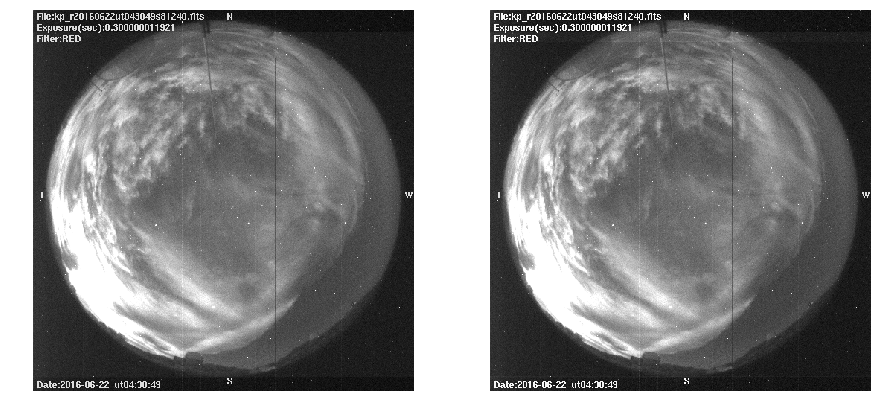

In [19]:
%%time
#name = 'r_ut081523s74880.png'
name = 'r_ut044344s61200.png'
#name = 'r_ut041252s80160.png'
name = 'r_ut043049s81240.png'
loc = os.path.join('../Images', *['fix1', name])
with open(loc, 'rb') as f:
    im = Image.open(f).convert('L')
    im = np.asarray(im)#.reshape((512, 512))
    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(im, cmap='gray')
ax[1].imshow(fix2(im), cmap='gray')

With the testing complete I ran a final test run by running all of the images I had at the time in my training set through and manually reviewing all of them. I needed the method to be somewhat quick, hence the profiled run to ensure that the actual band removal wasn't too slow. Since this might have to be performed on the fly in the network, it had to be speedy.

In [107]:
%%prun
pics = sorted(os.listdir(os.path.join('../Images', 'fix1')))

# Macs continue to be dumb two years later.
if '.DS_Store' in pics:
    pics.remove('.DS_Store')
    
for pic in pics:
    loc = os.path.join('../Images', *['fix1', pic])
    with open(loc, 'rb') as f:
        im = Image.open(f).convert('L')
        im = np.asarray(im)
        
    im2 = fix2(im)
    
    dpi = 128
    y = im2.shape[0] / dpi
    x = im2.shape[1] / dpi

    # Generate Figure and Axes objects.
    fig = plt.figure()
    fig.set_size_inches(x, y)
    ax = plt.Axes(fig, [0., 0., 1., 1.])  # 0 - 100% size of figure

    # Turn off the actual visual axes for visual niceness.
    # Then add axes to figure
    ax.set_axis_off()
    fig.add_axes(ax)

    # Adds the image into the axes and displays it
    # Then saves
    ax.imshow(im2, cmap='gray', vmin=0, vmax=255)
    
    loc = os.path.join('Images', *['fix2', pic])

    # Print "saved" after saving, in case saving messes up.
    plt.savefig(loc, dpi=dpi)
    print('Saved: ' + pic)

    # Close the plot in case you're running multiple saves.
    plt.close()

Saved: r_ut023150s56340.png
Saved: r_ut023450s56520.png
Saved: r_ut023749s56700.png
Saved: r_ut024049s56880.png
Saved: r_ut033118s74820.png
Saved: r_ut033417s75000.png
Saved: r_ut033717s75180.png
Saved: r_ut034016s75360.png
Saved: r_ut040150s50400.png
Saved: r_ut040450s50580.png
Saved: r_ut040953s79980.png
Saved: r_ut041252s80160.png
Saved: r_ut041422s65820.png
Saved: r_ut041552s80340.png
Saved: r_ut041721s66000.png
Saved: r_ut041851s80520.png
Saved: r_ut041947s51480.png
Saved: r_ut042021s66180.png
Saved: r_ut042151s80700.png
Saved: r_ut043049s81240.png
Saved: r_ut043145s52200.png
Saved: r_ut043349s81420.png
Saved: r_ut043445s52380.png
Saved: r_ut043648s81600.png
Saved: r_ut043744s52560.png
Saved: r_ut043745s60840.png
Saved: r_ut043948s81780.png
Saved: r_ut044044s52740.png
Saved: r_ut044044s61020.png
Saved: r_ut044247s81960.png
Saved: r_ut044343s52920.png
Saved: r_ut044344s61200.png
Saved: r_ut044547s82140.png
Saved: r_ut044643s53100.png
Saved: r_ut044942s53280.png
Saved: r_ut051039s54

         4826378 function calls (4748138 primitive calls) in 24.985 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      160   10.929    0.068   10.929    0.068 {built-in method matplotlib._png.write_png}
      160    1.921    0.012    1.921    0.012 {built-in method scipy.signal.sigtools._convolve2d}
      640    1.604    0.003    1.604    0.003 {built-in method scipy.ndimage._nd_image.min_or_max_filter1d}
      640    1.483    0.002    1.528    0.002 {built-in method matplotlib._image.resample}
   166880    0.580    0.000    0.580    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      320    0.506    0.002    3.598    0.011 image.py:258(_make_image)
   241120    0.460    0.000    0.489    0.000 {built-in method numpy.core.multiarray.array}
   151520    0.459    0.000    1.256    0.000 _methods.py:58(_mean)
      320    0.445    0.001    0.445    0.001 {method 'take' of 'numpy.ndarray' objects}
      160    0.371    0.